## Recurrent Neural Networks

In this notebook we will look at an advance model known as Recurrent Neural Networks or RNNs. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import load_functions as f
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.layers import Dense, Dropout, GRU, BatchNormalization

import sys
sys.path.append('..')
from Notebooks import ecg_cleaning as c

In [2]:
# File Path
path = '../data/physionet.org/files/ptb-xl/1.0.3/'
metadata = pd.read_csv('../data/cleaned_metadata.csv')

# Import data
full_data = f.load_signal(path, metadata)

In [3]:
# Data shape
full_data[0].shape, full_data[1].shape

((15677, 1000, 12), (15677,))

In [42]:
# Only looking at Lead II

X = full_data[0][:,:,1]

y = full_data[1]

X.shape, y.shape

((15677, 1000), (15677,))

### Binary Classification

In [44]:
def binary(diagnostic_list):
    if ast.literal_eval(diagnostic_list) != ['NORM']:
        diagnostic_list = 'ABNO'
    else:
        diagnostic_list = 'NORM'
    return diagnostic_list

In [45]:
y = y.apply(lambda x: binary(x))

In [46]:
y.value_counts()

ABNO    8645
NORM    7032
Name: diagnostic_superclass, dtype: int64

In [47]:
# Instantiate LabelEncoder
label = LabelEncoder()

# Fit target column
label.fit(y)

# Transform target column 
y = label.transform(y)

In [148]:
label.transform(['ABNO', 'NORM'])

array([0, 1])

In [51]:
# Low sampling frequency
sig_len = 1000
sampling_frequency = 100
time = np.arange(0, sig_len) / sampling_frequency

# Baseline and PLI removal

signal_bl = pd.DataFrame(X).apply(lambda x: c.baseline_removal(x, freq_start=0.1, freq_stop=1.5))
signal_pli = pd.DataFrame(signal_bl).apply(lambda x: c.high_freq_removal(x, freq_start=45))

In [52]:
# Reshape it into 3D 
signal_pli = signal_pli.values.reshape(-1, 1000, 1).astype("float")

In [53]:
X_train, X_test, y_train, y_test = train_test_split(signal_pli, y, test_size=0.2, stratify=y, random_state=42)

X_train.shape, y_train.shape

((12541, 1000, 1), (12541,))

In [126]:
rnn_model = keras.Sequential([
    # the intermediate recurrent layers should return full sequences
    GRU(16, activation='relu', return_sequences=True),
    BatchNormalization(),
    Dropout(0.15),

    # the last recurrent layer only returns the final output
    GRU(16, activation='relu', return_sequences=False),
    BatchNormalization(),
    Dropout(0.15),

    # output layer
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.15),
    Dense(2, activation='softmax')],
)

In [127]:
# Compile our model with an optimizer, loss function and metric to look at
rnn_model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.01),  # learning rate can be adjusted here
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [130]:
# Set callbacks
callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          verbose=1, 
                                          restore_best_weights=True,
                                          patience=3
)

# Fit our model, adding a validation set as well 
history = rnn_model.fit(X_train, 
                    y_train, 
                    batch_size=32,
                    epochs=10, 
                    validation_split=0.1,
                    callbacks=[callbacks]
)

Epoch 1/10
353/353 [==============================] - 184s 512ms/step - loss: 0.6505 - sparse_categorical_accuracy: 0.6165 - val_loss: 1.5967 - val_sparse_categorical_accuracy: 0.4590
Epoch 2/10
353/353 [==============================] - 175s 495ms/step - loss: 0.4706 - sparse_categorical_accuracy: 0.7805 - val_loss: 0.4346 - val_sparse_categorical_accuracy: 0.8207
Epoch 3/10
353/353 [==============================] - 174s 494ms/step - loss: 0.4431 - sparse_categorical_accuracy: 0.7960 - val_loss: 0.7993 - val_sparse_categorical_accuracy: 0.6279
Epoch 4/10
353/353 [==============================] - 184s 521ms/step - loss: 0.4356 - sparse_categorical_accuracy: 0.8058 - val_loss: 0.4306 - val_sparse_categorical_accuracy: 0.8104
Epoch 5/10
353/353 [==============================] - 179s 508ms/step - loss: 0.4221 - sparse_categorical_accuracy: 0.8091 - val_loss: 0.9885 - val_sparse_categorical_accuracy: 0.5896
Epoch 6/10
353/353 [==============================] - 184s 523ms/step - loss: na

In [131]:
rnn_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_24 (GRU)                (None, 1000, 16)          912       
                                                                 
 batch_normalization_36 (Bat  (None, 1000, 16)         64        
 chNormalization)                                                
                                                                 
 dropout_36 (Dropout)        (None, 1000, 16)          0         
                                                                 
 gru_25 (GRU)                (None, 16)                1632      
                                                                 
 batch_normalization_37 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dropout_37 (Dropout)        (None, 16)              

In [136]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][3]
result = rnn_model.evaluate(X_test, y_test, verbose=0)
#result = rnn_model.evaluate(np.real(X_test.values.reshape(-1, 1000, 1)), y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.8058
Test Accuracy: 0.8010


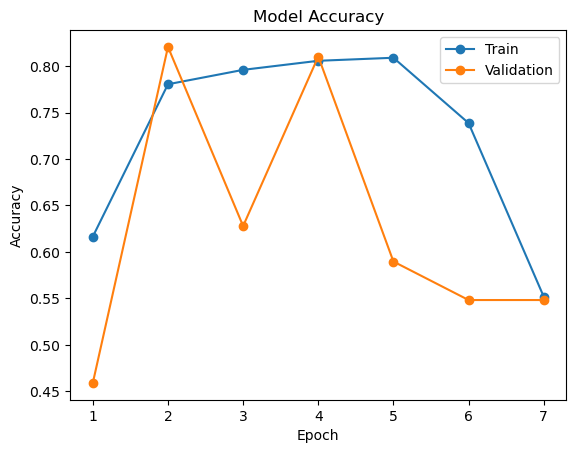

In [155]:
epochs = range(1, 8)

# Plotting accuracy function 
plt.plot(epochs, history.history['sparse_categorical_accuracy'], marker='o')
plt.plot(epochs, history.history['val_sparse_categorical_accuracy'], marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

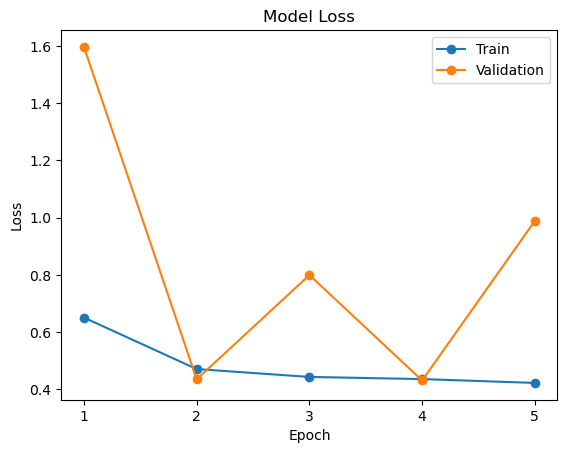

In [156]:
# Plotting loss function 
plt.plot(epochs, history.history['loss'], marker='o')
plt.plot(epochs, history.history['val_loss'], marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(epochs[:5:1])
plt.legend(['Train', 'Validation'])
plt.show()

> Only shows for 5 epochs because last two epochs are `NaN`, possibly because of exploding gradients

In [149]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the predicted labels for each test image.
predict_probas = rnn_model.predict(X_test)
y_predict = np.argmax(predict_probas, axis=1)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_predict)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Abnormal", "Predicted Normal"],
    index=["True Abnormal", "True Normal"]
)

display(cf_df)

,Predicted Abnormal,Predicted Normal
True Abnormal,1525,204
True Normal,420,987


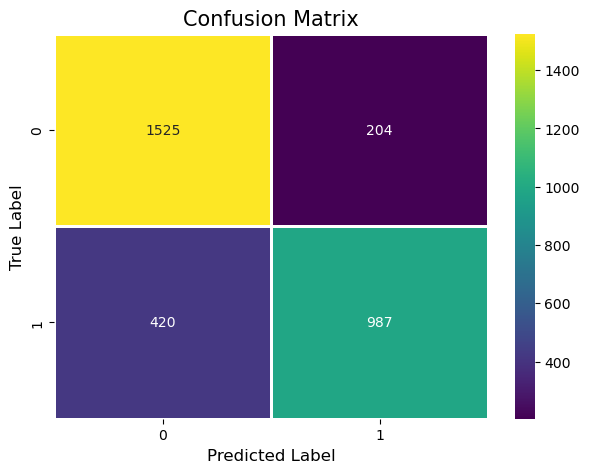

In [179]:
plt.figure(figsize=(7,5))
sns.heatmap(cf_matrix,
            annot=True,
            cbar=True,
            cmap="viridis",
            linewidths=1,
            fmt='d'
)
plt.title('Confusion Matrix', size=15)
plt.xlabel("Predicted Label", size=12)
plt.ylabel("True Label", size=12)
plt.show()

In [182]:
987/(987+420)

0.7014925373134329

In [154]:
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_predict)
print(cr)

              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1729
           1       0.83      0.70      0.76      1407

    accuracy                           0.80      3136
   macro avg       0.81      0.79      0.79      3136
weighted avg       0.80      0.80      0.80      3136



In [167]:
y_test.shape

(3136,)

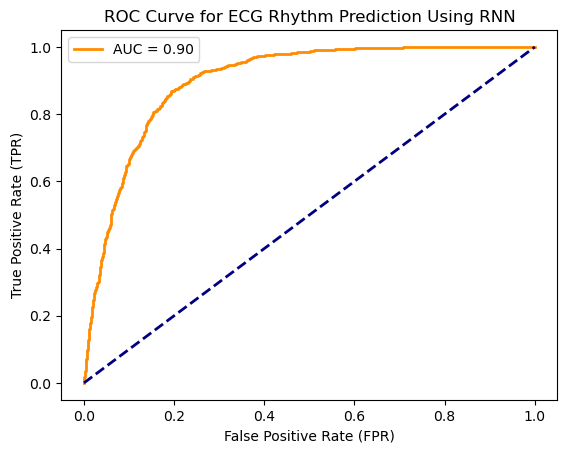

Area under curve (AUC):0.9013817140851144



In [184]:
from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_test, predict_probas[:, 1])
roc_auc = roc_auc_score(y_test, predict_probas[:, 1])

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for ECG Rhythm Prediction Using RNN')
plt.legend(loc="best")
plt.savefig('roc_curve.jpg')
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

#### Save model as pickle

- https://edwarda-johnson.medium.com/ai-as-ghostwriter-different-ways-to-save-your-machine-learning-model-f8d4432e893


In [185]:
import pickle

with open('rnn_binary.pkl', 'wb') as file:
    pickle.dump(rnn_model, file)

2024-04-12 02:18:25.022445: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://ec41f544-4f6b-4245-80e0-bc216df8a94b/assets
